In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
from models.sub_tcn import Sub_TCN
from models.gru import GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

final_no = 6
E_neural *= 1/final_no
I_neural *= 1/final_no
V *= 1/final_no

eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 20
sub_no = 1
E_no = 299
I_no = 8
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train 

In [4]:
C_syn_e = torch.ones((1, E_no))
C_syn_i = torch.ones((1, I_no))

# Preprocess

In [5]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [6]:
#model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.)

# TCN (1. for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

# GRU (1 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1709


In [7]:
score_list = []
model.V_o.requires_grad=False

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    s = time.time()
    
    loss = torch.mean((V_pred - batch_V[:,5000:35000])**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[5000:35000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[5000:35000]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-7-f56a11ac3124>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.021263 0.007432
49 0.020382 0.001239
99 0.071881 0.001147
149 0.182633 0.001011
199 0.190066 0.001001
249 0.185275 0.001007
299 0.18542 0.001007
349 0.18877 0.001003
399 0.190994 0.001
449 0.194855 0.000995
499 0.196871 0.000993
549 0.199152 0.00099
599 0.201576 0.000987
649 0.202834 0.000985
699 0.205206 0.000983
749 0.207821 0.00098
799 0.210223 0.000977
849 0.213588 0.000973
899 0.215881 0.000969


KeyboardInterrupt: 

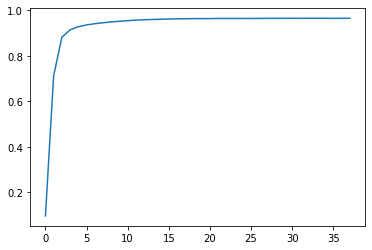

In [7]:
plt.plot(np.asarray(score_list))


Parameter containing:
tensor([0.], device='cuda:0')


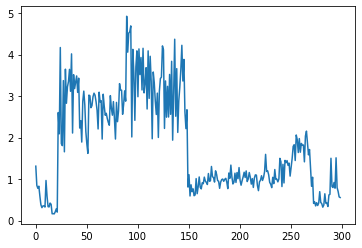

In [10]:
plt.plot(np.exp(model.E_scale.cpu().detach().numpy()))
print(model.V_o)

In [11]:
E_scale = model.E_scale.cpu().detach().numpy()
I_scale = model.I_scale.cpu().detach().numpy()
gru_w_ih = model.rnn[0].weight_ih_l0.cpu().detach().numpy()
gru_w_hh = model.rnn[0].weight_hh_l0.cpu().detach().numpy()
gru_b_ih = model.rnn[0].bias_ih_l0.cpu().detach().numpy()
gru_b_hh = model.rnn[0].bias_hh_l0.cpu().detach().numpy()
lin_w = model.linear[0].weight.cpu().detach().numpy()
lin_b = model.linear[0].bias.cpu().detach().numpy()
V_o = model.V_o.cpu().detach().numpy()

In [12]:
#np.savez("/media/hdd01/sklee/CA1_clust4-60/clust/gru_clust_s1_h20_pretrain.npz",
       E_scale=E_scale,
       I_scale=I_scale,
       gru_w_ih=gru_w_ih,
       gru_w_hh=gru_w_hh,
       gru_b_ih=gru_b_ih,
       gru_b_hh=gru_b_hh,
       lin_w=lin_w,
       lin_b=lin_b,
        V_o=V_o)